In [1]:
import pandas as pd
import numpy as np
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from gap_statistic import OptimalK
import matplotlib.pyplot as plt
import GCKM as G

In [143]:
income = pd.read_csv("American_Income.csv")

In [144]:
G = G.GaussianCopulaKmeansSynthesizer(income)
G._identify_columns()
G.convert_datetime_to_numerical()
G.handle_missing_values()
G.assign_intervals()
G.preprocess_data()

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [01:54<00:00, 12.67s/it]


In [145]:
data_all_num = G.data

data_all_num

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,0.912968,77516,0.610237,13,0.638385,0.440297,0.524163,0.629820,0.376605,2174,0,40,0.535233,0.108446
1,50,0.748326,83311,0.653272,13,0.214637,0.319936,0.314220,0.474808,0.403805,0,0,13,0.494146,0.404423
2,38,0.342428,215646,0.172450,9,0.924295,0.891098,0.573821,0.586582,0.393037,0,0,40,0.351300,0.406672
3,53,0.106867,234721,0.828189,7,0.122175,0.905090,0.303684,0.921898,0.398519,0,0,40,0.504057,0.274545
4,28,0.384483,338409,0.644147,13,0.191226,0.061916,0.947726,0.858541,0.832562,0,0,40,0.959054,0.289335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,0.552294,257302,0.850272,12,0.330796,0.955776,0.938243,0.502747,0.885283,0,0,38,0.401742,0.420956
32557,40,0.287407,154374,0.154456,9,0.254483,0.716436,0.252708,0.378964,0.409342,0,0,40,0.357760,0.942847
32558,58,0.404730,151910,0.238843,9,0.971758,0.452459,0.911432,0.531691,0.885300,0,0,40,0.374448,0.427328
32559,22,0.380851,201490,0.217776,9,0.630890,0.436491,0.785455,0.559080,0.345939,0,0,20,0.232766,0.377798


In [4]:
def optimal_clusters_dynamic(data, ax):
        # Calculate the covariance matrix
        data_df = pd.DataFrame(data = data)
        cov_matrix = np.cov(data_df, rowvar=False)
        
        # Perform eigenvalue decomposition
        eigenvalues, _ = np.linalg.eig(cov_matrix)
        
        # Sort the eigenvalues in descending order
        sorted_eigenvalues = np.sort(eigenvalues)[::-1]
        
        # Calculate the percentage change between consecutive eigenvalues
        delta_eigenvalues = np.diff(sorted_eigenvalues) / sorted_eigenvalues[:-1]
        largest_drop_index = np.argmin(delta_eigenvalues)
        num_clusters = largest_drop_index + 1


        # # Calculate percentiles for categorizing delta eigenvalues
        # lower_percentile = np.percentile(delta_eigenvalues, 25)
        # upper_percentile = np.percentile(delta_eigenvalues, 75)

        # # Identifying potential cluster boundaries
        # cluster_boundaries = []
        # for i, delta in enumerate(delta_eigenvalues):
        #     if delta > upper_percentile or (lower_percentile < delta < upper_percentile):
        #         cluster_boundaries.append(i)

        # num_clusters = len(cluster_boundaries) + 1 if cluster_boundaries else 1
        # ax.plot(range(1, len(sorted_eigenvalues) + 1), sorted_eigenvalues, marker='o')
        # ax.set_title('Eigenvalues in Descending Order')
        # ax.set_xlabel('Index of Eigenvalue')
        # ax.set_ylabel('Eigenvalue')
        
        # ax2 = ax.twinx()
        # ax2.plot(range(2, len(sorted_eigenvalues) + 1), delta_eigenvalues, marker='o', color='red')
        # ax2.set_ylabel('Rate of Change of Eigenvalue', color='red')
        # ax2.tick_params(axis='y', labelcolor='red')
        
        # # Mark the largest drop with an 'X'
        # ax2.axvline(x=num_clusters + 1, color='red', linestyle='--')
        # ax2.annotate('Largest drop here', xy=(num_clusters+1, delta_eigenvalues[largest_drop_index]), 
        #             xytext=(num_clusters+1, delta_eigenvalues[largest_drop_index] + 0.05),
        #             arrowprops=dict(facecolor='red', shrink=0.05), color='red')
    
        return num_clusters+1, delta_eigenvalues, eigenvalues

In [3]:
def optimal_clusters_dynamic2(data, ax, lower_percentile_threshold=25, upper_percentile_threshold=75):
    # Calculate the covariance matrix
    data_df = pd.DataFrame(data=data)
    cov_matrix = np.cov(data_df, rowvar=False)

    # Perform eigenvalue decomposition
    eigenvalues, _ = np.linalg.eig(cov_matrix)

    # Sort the eigenvalues in descending order
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]

    # Calculate the percentage change between consecutive eigenvalues
    delta_eigenvalues = np.diff(sorted_eigenvalues) / sorted_eigenvalues[:-1]
    largest_drop_index = np.argmin(delta_eigenvalues)

    # Calculate percentiles for categorizing delta eigenvalues
    lower_percentile = np.percentile(delta_eigenvalues, lower_percentile_threshold)
    upper_percentile = np.percentile(delta_eigenvalues, upper_percentile_threshold)

    # Identifying potential cluster boundaries
    cluster_boundaries = []
    for i, delta in enumerate(delta_eigenvalues):
        if delta > upper_percentile or (lower_percentile < delta < upper_percentile):
            cluster_boundaries.append(i)

    # Combine the largest drop method with percentile-based approach
    num_clusters = len(cluster_boundaries) + 1 if cluster_boundaries else largest_drop_index + 1

    # Plotting
    ax.plot(range(1, len(sorted_eigenvalues) + 1), sorted_eigenvalues, marker='o')
    ax.set_title('Eigenvalues in Descending Order')
    ax.set_xlabel('Index of Eigenvalue')
    ax.set_ylabel('Eigenvalue')

    ax2 = ax.twinx()
    ax2.plot(range(2, len(sorted_eigenvalues) + 1), delta_eigenvalues, marker='o', color='red')
    ax2.set_ylabel('Rate of Change of Eigenvalue', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Mark the largest drop and potential cluster boundaries
    ax2.axvline(x=largest_drop_index + 2, color='green', linestyle='--')
    for boundary in cluster_boundaries:
        ax2.axvline(x=boundary + 2, color='blue', linestyle='--')
    ax2.annotate('Largest drop here', xy=(largest_drop_index+2, delta_eigenvalues[largest_drop_index]),
                 xytext=(largest_drop_index+2, delta_eigenvalues[largest_drop_index] + 0.05),
                 arrowprops=dict(facecolor='green', shrink=0.05), color='green')

    return num_clusters, delta_eigenvalues, eigenvalues

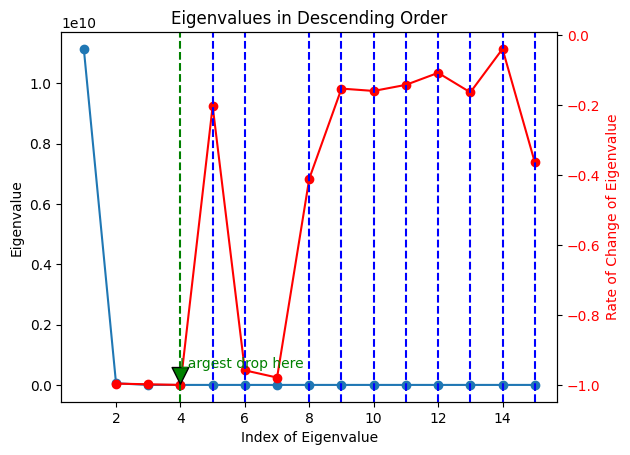

The optimal number of clusters determined by the function is: 11
[-0.99510424 -0.99702621 -0.99885363 -0.20202701 -0.95718533 -0.97782204
 -0.40914828 -0.15178818 -0.15851093 -0.14107643 -0.10675731 -0.16253213
 -0.03838628 -0.36165664]
--------------------------
[1.11407978e+10 5.45426939e+07 1.62198332e+05 1.85938688e+02
 1.48374051e+02 6.35258543e+00 1.40887368e-01 8.32435436e-02
 2.34342196e-02 7.06081575e-02 5.94159928e-02 5.10337964e-02
 4.55855654e-02 3.67109946e-02 3.81764462e-02]


In [171]:
fig, ax = plt.subplots()
optimal_num_clusters,delta_eigenvalues, eigenvalues = optimal_clusters_dynamic2(data_all_num, ax)
plt.show()
print(f"The optimal number of clusters determined by the function is: {optimal_num_clusters}")
print(delta_eigenvalues)
print("--------------------------")
print(eigenvalues)

In [166]:
def evaluate_clustering_methods(data, max_clusters):
    silhouette_scores = []
    db_scores = []
    gap_stats = []

    for n_clusters in range(2, max_clusters + 1):
        # KMeans clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(data)

        # Silhouette Score
        silhouette_avg = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)

        # Davies-Bouldin Score
        db_score = davies_bouldin_score(data, kmeans.labels_)
        db_scores.append(db_score)

    # Gap Statistic
    optimalK = OptimalK(parallel_backend='joblib')
    n_clusters_gap = optimalK(data, cluster_array=np.arange(1, max_clusters + 1))
    gap_stats = optimalK.gap_df['gap_value'].tolist()

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(18, 10))  # Create a grid of subplots
    
    axs[0, 0].plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    axs[0, 0].set_title('Silhouette Score')
    axs[0, 0].set_xlabel('Number of clusters')
    axs[0, 0].set_ylabel('Silhouette Score')

    axs[0, 1].plot(range(2, max_clusters + 1), db_scores, marker='o')
    axs[0, 1].set_title('Davies-Bouldin Score')
    axs[0, 1].set_xlabel('Number of clusters')
    axs[0, 1].set_ylabel('DB Index')

    axs[1, 0].plot(range(1, max_clusters + 1), gap_stats, marker='o')
    axs[1, 0].set_title('Gap Statistic')
    axs[1, 0].set_xlabel('Number of clusters')
    axs[1, 0].set_ylabel('Gap Statistic')

    num_cluster = optimal_clusters_dynamic(data, axs[1, 1])

    plt.tight_layout()
    plt.show()

    return silhouette_scores, db_scores, gap_stats, num_cluster




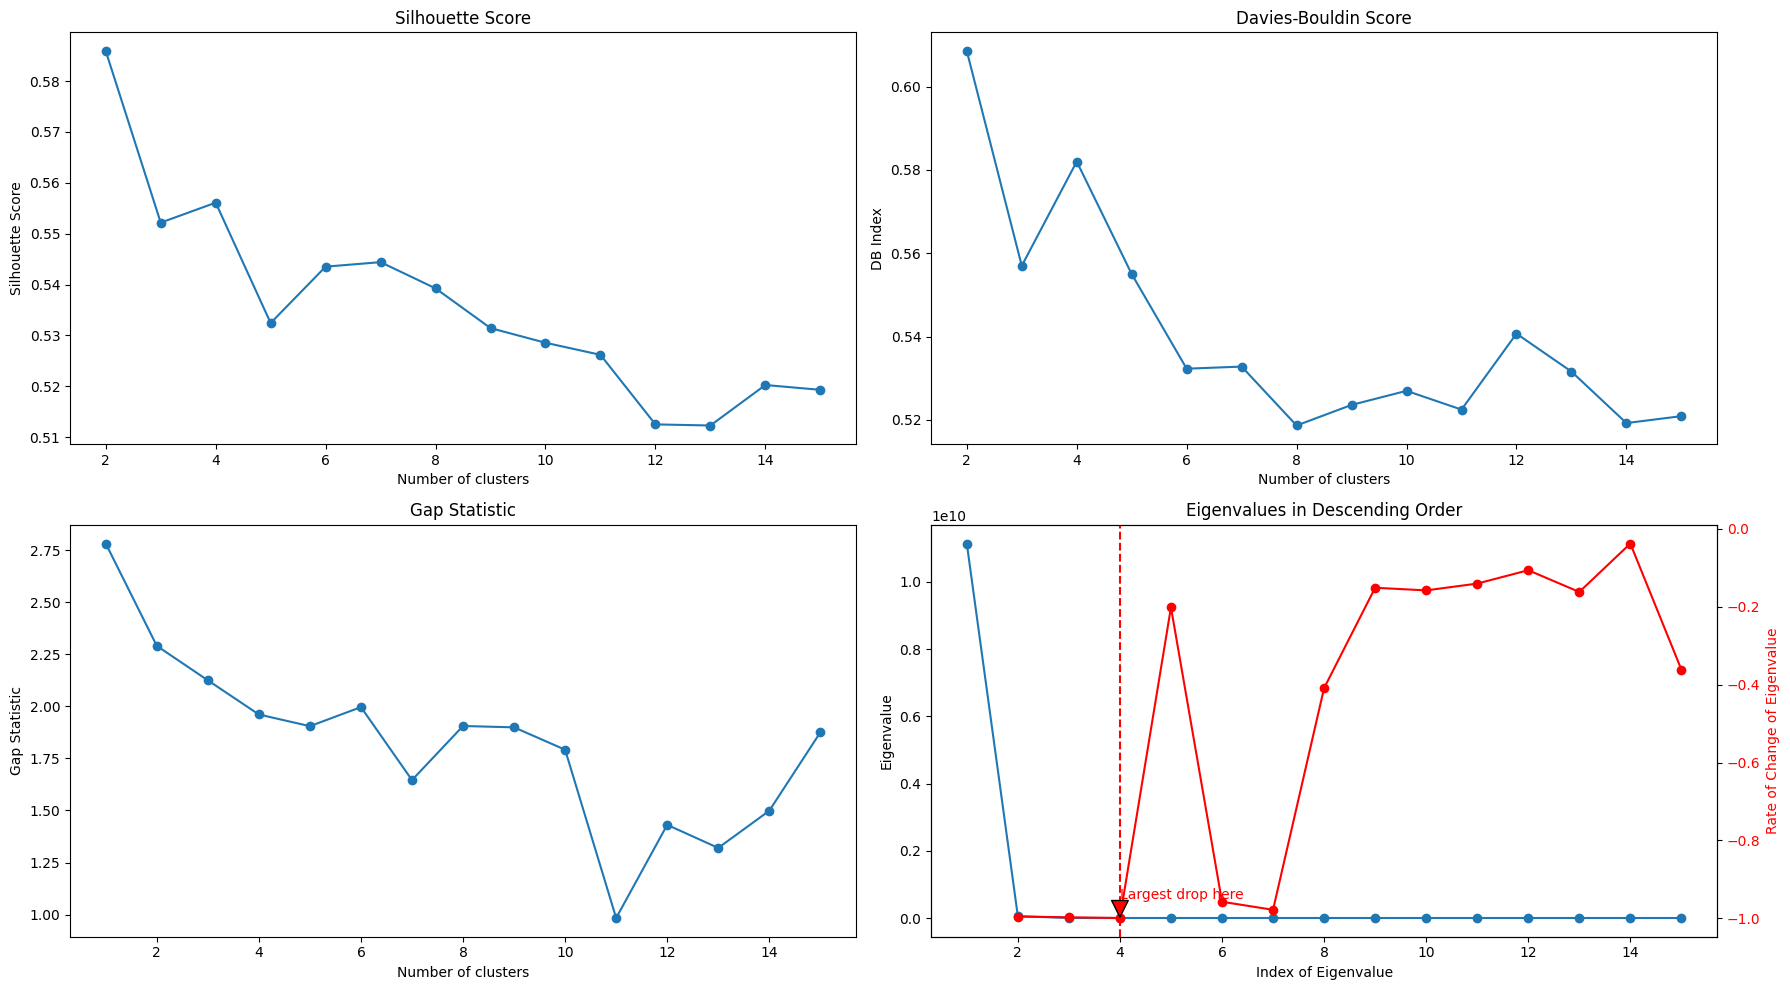

In [160]:
silhouette_scores, db_scores, gap_stats, num_clusters = evaluate_clustering_methods(data_all_num, max_clusters=15)

In [161]:
from sklearn.datasets import make_blobs

X_high_dim, _ = make_blobs(n_samples=700, centers=7, cluster_std=0.60, n_features=10, random_state=0)
data_df_high_dim = pd.DataFrame(X_high_dim)

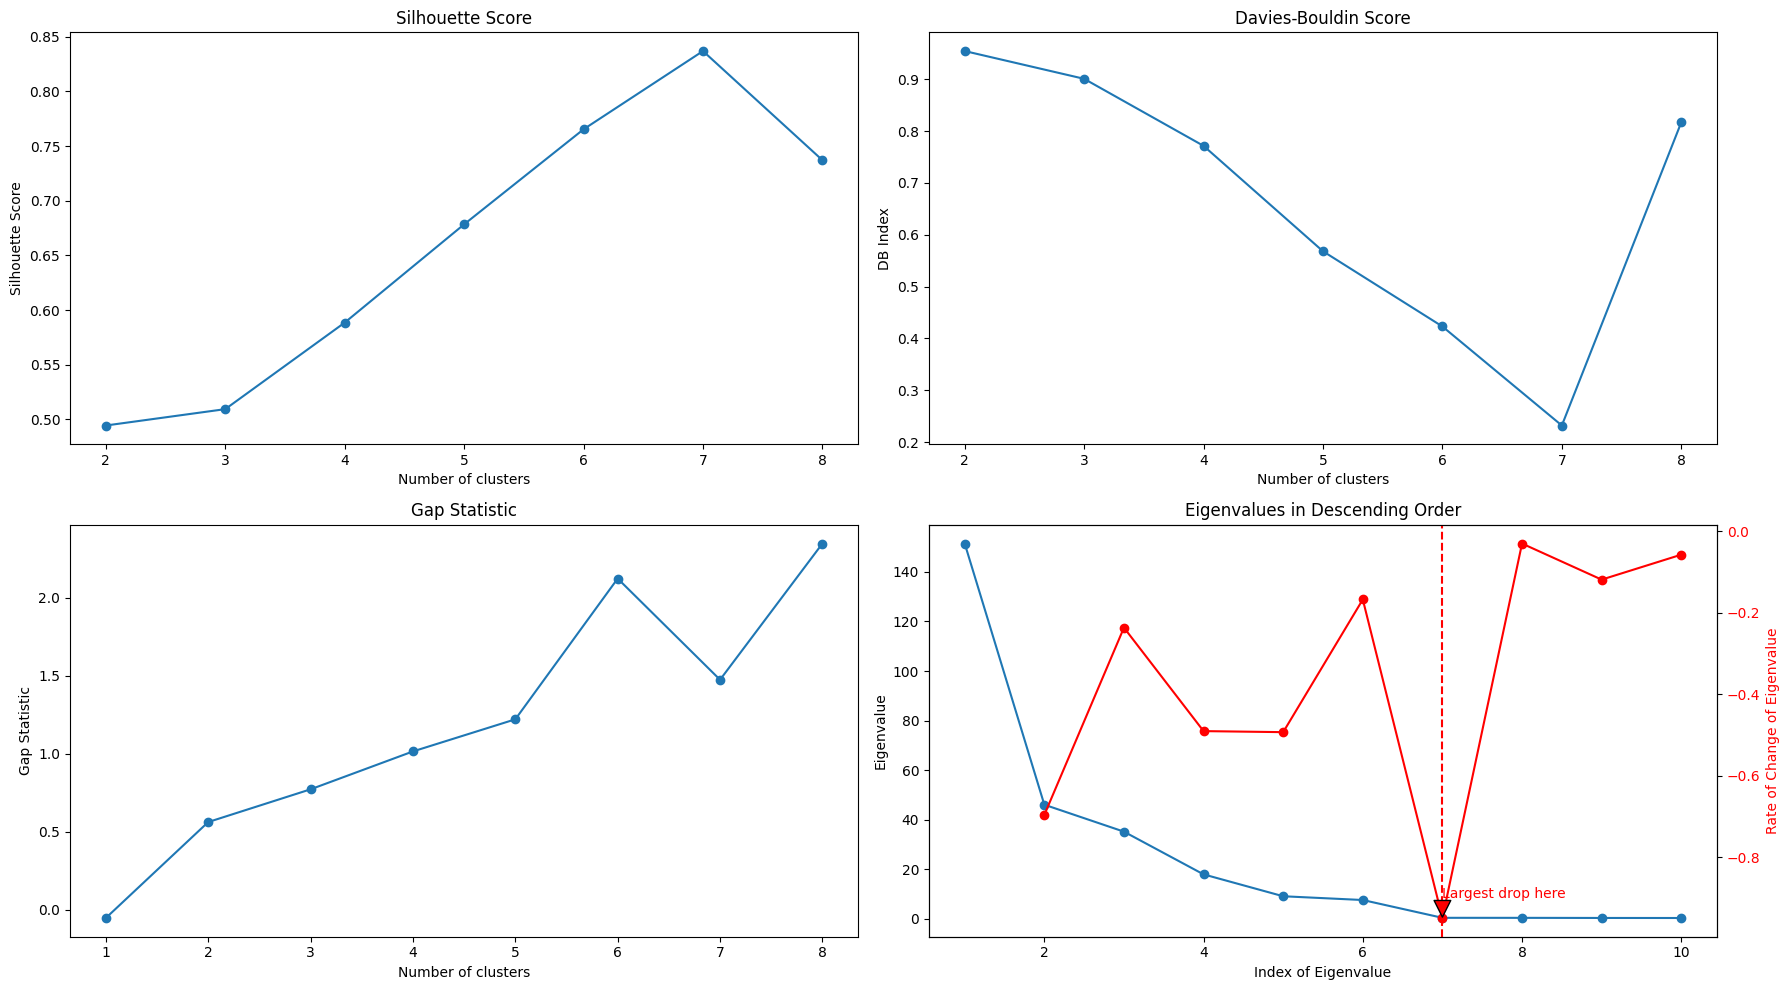

In [162]:
silhouette_scores, db_scores, gap_stats, num_clusters = evaluate_clustering_methods(data_df_high_dim, max_clusters=8)

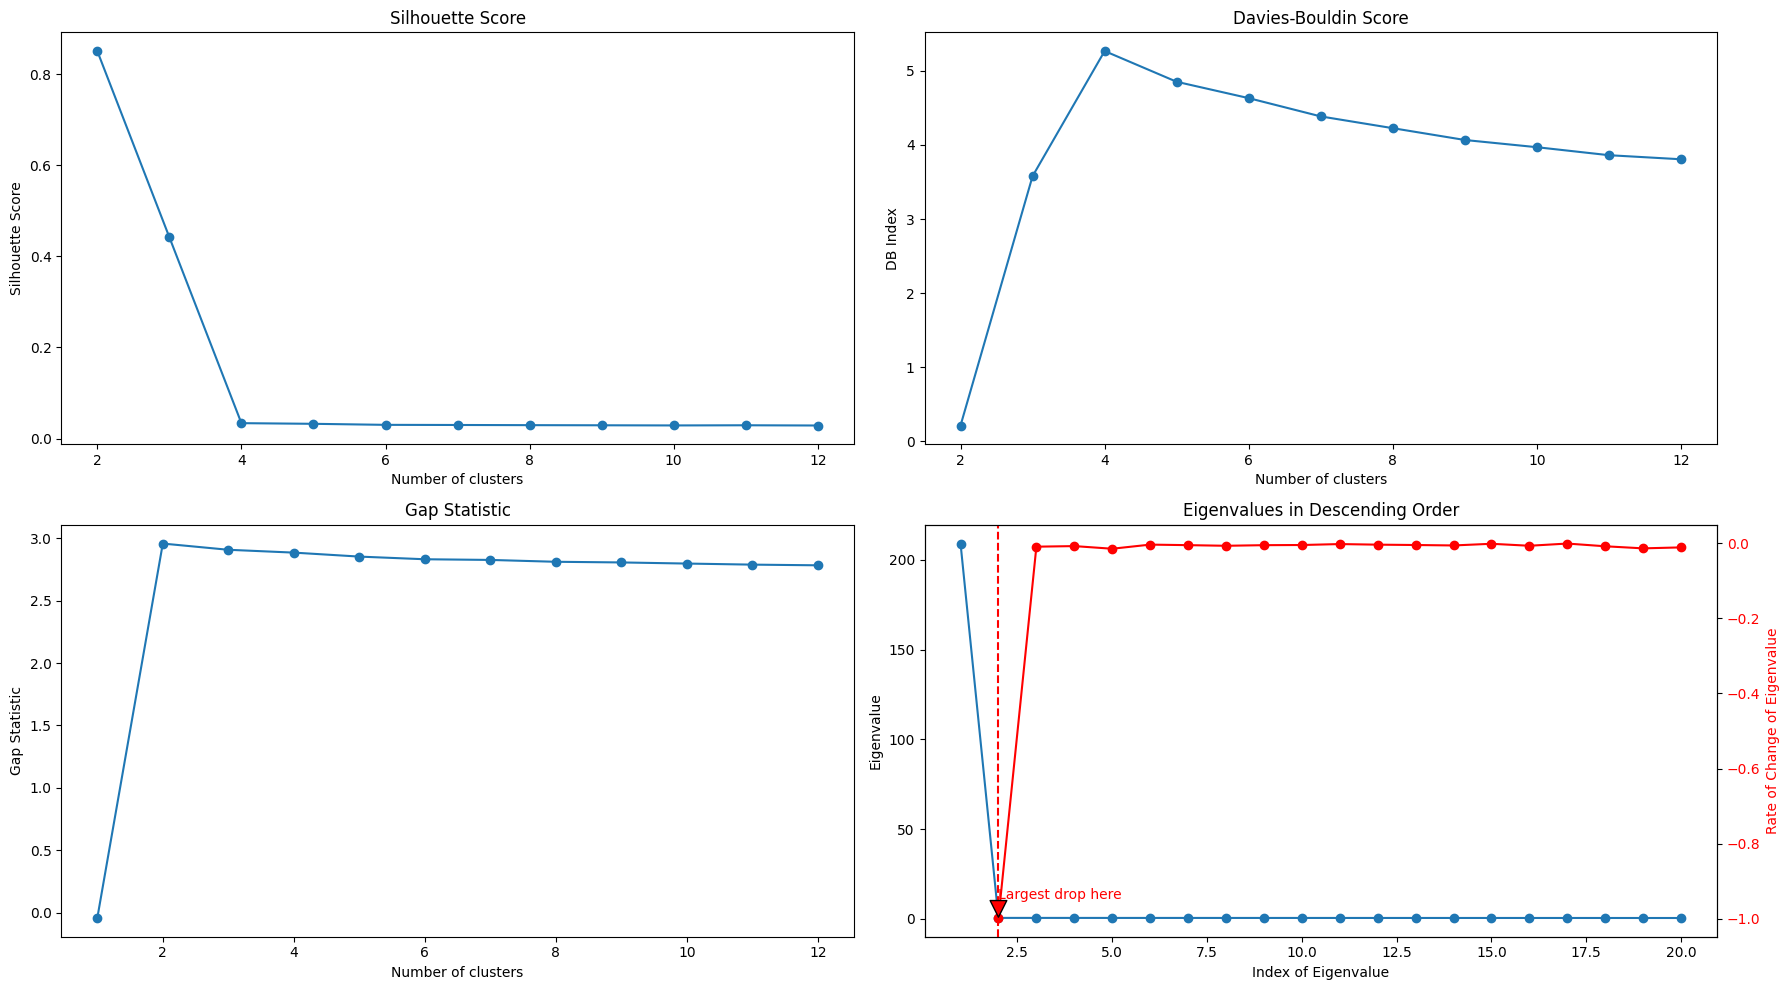

In [164]:
from sklearn.datasets import make_blobs

X_high_dim, _ = make_blobs(n_samples=20000, centers = 2, cluster_std=0.70, n_features=20, random_state=2)
data_df_high_dim = pd.DataFrame(X_high_dim)


silhouette_scores, db_scores, gap_stats, num_clusters = evaluate_clustering_methods(data_df_high_dim, max_clusters=12)

In [165]:
num_clusters

(2,
 array([-0.99752427, -0.00933346, -0.00779352, -0.01482418, -0.00384419,
        -0.0052721 , -0.00694301, -0.00533503, -0.00490183, -0.0023968 ,
        -0.00396195, -0.004905  , -0.00608375, -0.00161939, -0.00690787,
        -0.00103106, -0.00827837, -0.01381305, -0.01123453]),
 array([209.06535469,   0.45952165,   0.51759027,   0.51275936,
          0.46474282,   0.50876316,   0.47125225,   0.47518602,
          0.47567647,   0.50122116,   0.49929437,   0.49666204,
          0.47898524,   0.47976216,   0.48269878,   0.49321372,
          0.48507809,   0.48700759,   0.48817765,   0.4905824 ]))

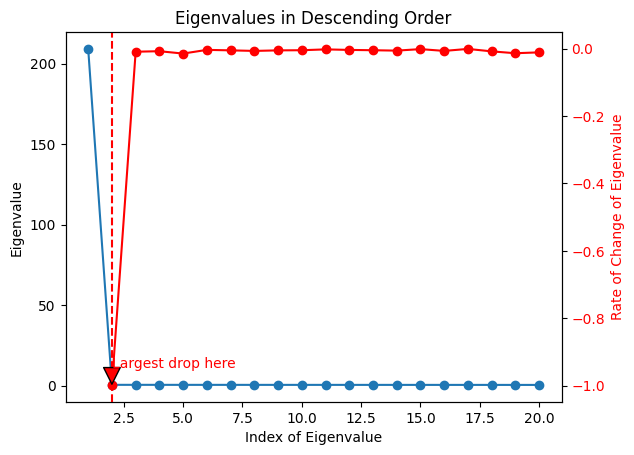

The optimal number of clusters determined by the function is: 2
[-0.99752427 -0.00933346 -0.00779352 -0.01482418 -0.00384419 -0.0052721
 -0.00694301 -0.00533503 -0.00490183 -0.0023968  -0.00396195 -0.004905
 -0.00608375 -0.00161939 -0.00690787 -0.00103106 -0.00827837 -0.01381305
 -0.01123453]
--------------------------
[209.06535469   0.45952165   0.51759027   0.51275936   0.46474282
   0.50876316   0.47125225   0.47518602   0.47567647   0.50122116
   0.49929437   0.49666204   0.47898524   0.47976216   0.48269878
   0.49321372   0.48507809   0.48700759   0.48817765   0.4905824 ]


In [167]:
fig, ax = plt.subplots()
optimal_num_clusters,delta_eigenvalues, eigenvalues = optimal_clusters_dynamic(data_df_high_dim, ax)
plt.show()
print(f"The optimal number of clusters determined by the function is: {optimal_num_clusters}")
print(delta_eigenvalues)
print("--------------------------")
print(eigenvalues)

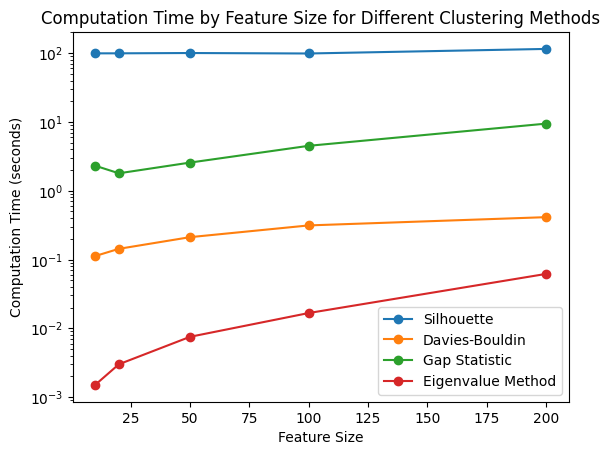

In [16]:
import time
from sklearn.datasets import make_blobs


def evaluate_clustering_methods(data, max_clusters):
    times = {'Silhouette': 0, 'Davies-Bouldin': 0, 'Gap Statistic': 0, 'Eigenvalue Method': 0}
    silhouette_scores = []
    db_scores = []
    silhouette_times = []
    db_times = []

    # Silhouette and Davies-Bouldin Scores
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(data)

        # Silhouette Score
        start_time = time.time()
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)
        silhouette_times.append(time.time() - start_time)

        # Davies-Bouldin Score
        start_time = time.time()
        score = davies_bouldin_score(data, kmeans.labels_)
        db_scores.append(score)
        db_times.append(time.time() - start_time)

    # Determine the best index (optimal number of clusters) for Silhouette and Davies-Bouldin
    best_silhouette_index = np.argmax(silhouette_scores)
    best_db_index = np.argmin(db_scores)

    # Sum up the times up to the best index
    times['Silhouette'] = sum(silhouette_times[:best_silhouette_index + 1])
    times['Davies-Bouldin'] = sum(db_times[:best_db_index + 1])

    # Gap Statistic
    start_time = time.time()
    OptimalK(parallel_backend='joblib')(data, cluster_array=np.arange(1, max_clusters + 1))
    times['Gap Statistic'] = time.time() - start_time

    # Eigenvalue Method
    start_time = time.time()
    optimal_clusters_dynamic(data, None)
    times['Eigenvalue Method'] = time.time() - start_time

    return times

def test_different_sizes(num_feature, num_data, max_clusters, option):
    all_times = {method: [] for method in ['Silhouette', 'Davies-Bouldin', 'Gap Statistic', 'Eigenvalue Method']}

    if option == "Feature":
        all_times['Feature Size'] = num_feature

        for size in num_feature:
            X, _ = make_blobs(n_samples=30000, centers=11, cluster_std=0.60, n_features=size, random_state=0)
            times = evaluate_clustering_methods(X, max_clusters)
            for method in times:
                all_times[method].append(times[method])  # Append the total time
        return pd.DataFrame(all_times)
    
    elif option == "Data":
        all_times['Data Size'] = num_data

        for data in num_data:
            X, _ = make_blobs(n_samples=data, centers=11, cluster_std=0.60, n_features=20, random_state=0)
            times = evaluate_clustering_methods(X, max_clusters)
            for method in times:
                all_times[method].append(times[method])  # Append the total time
        return pd.DataFrame(all_times)

# Sample sizes to test
num_feature = [10, 20, 50, 100, 200]
num_data = [2500,5000,7500,10000,30000,50000]
# Testing and plotting
time_df = test_different_sizes(num_feature, num_data, 13,"Feature")
plt.plot('Feature Size', 'Silhouette', data=time_df, marker='o', label='Silhouette')
plt.plot('Feature Size', 'Davies-Bouldin', data=time_df, marker='o', label='Davies-Bouldin')
plt.plot('Feature Size', 'Gap Statistic', data=time_df, marker='o', label='Gap Statistic')
plt.plot('Feature Size', 'Eigenvalue Method', data=time_df, marker='o', label='Eigenvalue Method')

plt.xscale('linear')  
plt.yscale('log')  # Applying a logarithmic scale to the y-axis

plt.xlabel('Feature Size')
plt.ylabel('Computation Time (seconds)')
plt.title('Computation Time by Feature Size for Different Clustering Methods')
plt.legend()
plt.show()

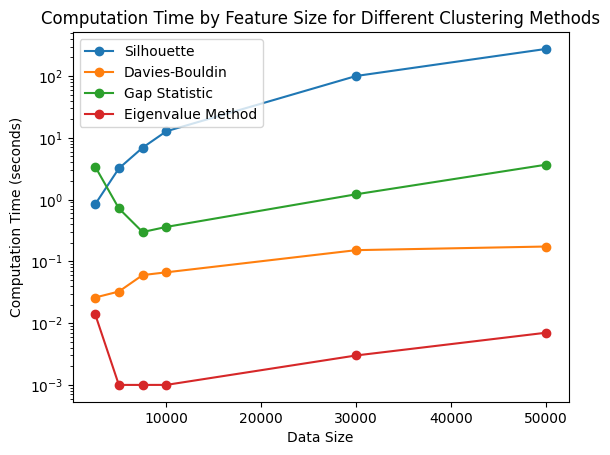

In [19]:
num_feature = [10, 20, 50, 100, 200]
num_data = [2500,5000,7500,10000,30000,50000]
# Testing and plotting
time_df = test_different_sizes(num_feature, num_data, 13,"Data")
plt.plot('Data Size', 'Silhouette', data=time_df, marker='o', label='Silhouette')
plt.plot('Data Size', 'Davies-Bouldin', data=time_df, marker='o', label='Davies-Bouldin')
plt.plot('Data Size', 'Gap Statistic', data=time_df, marker='o', label='Gap Statistic')
plt.plot('Data Size', 'Eigenvalue Method', data=time_df, marker='o', label='Eigenvalue Method')

plt.xscale('linear')  
plt.yscale('log')  # Applying a logarithmic scale to the y-axis

plt.xlabel('Data Size')
plt.ylabel('Computation Time (seconds)')
plt.title('Computation Time by Feature Size for Different Clustering Methods')
plt.legend()
plt.show()

In [10]:
time_df

,Silhouette,Davies-Bouldin,Gap Statistic,Eigenvalue Method,Feature Size
0,10.520317,0.012104,2.111667,0.002001,10
1,10.593390,0.016504,1.539705,0.003003,20
2,10.598769,0.022842,2.018006,0.008002,50
